# III Portfolio insurance strategy
For this task, assume a fictive investor with an investment horizon of T ∗ = 1 year, planning to invest 10,000 euros. Assume that the investor has the possibility to invest in a stock or index, and put options for portfolio insurance purposes

## III.1 Performance analysis (without risk management)

Use a Monte-Carlo simulation to derive the payoff/return distribution at the end of the investment horizon T ∗ of an investment in the stock/index. Calculate meaningful performance and risk measures and explain.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

In [537]:
#read in Microsoft Stock Data
microsoft = pd.read_csv("./data/microsoft_5_years.csv", delimiter=";")
microsoft["Schluss"] = microsoft['Schluss'].str.replace('.', '', regex=False).str.replace(',', '.', regex=False).astype(float)
microsoft['Eröffnung'] = microsoft['Eröffnung'].str.replace('.', '', regex=False).str.replace(',', '.', regex=False).astype(float)
microsoft['Hoch'] = microsoft['Hoch'].str.replace('.', '', regex=False).str.replace(',', '.', regex=False).astype(float)
microsoft['Tief'] = microsoft['Tief'].str.replace('.', '', regex=False).str.replace(',', '.', regex=False).astype(float)
microsoft["Datum"] = pd.to_datetime(microsoft["Datum"], dayfirst=True)

microsft = pd.DataFrame(microsoft)

In [538]:
# Splitting the data into prices before 01.07.2024 and after. Later is used for comparison to simulated prices. 
july_2024_index = microsoft[(microsoft['Datum'] <= '2024-06-30')].index
prices_after_july_2024 = microsoft.drop(july_2024_index)
prices_before_july_2024 = microsoft.iloc[:july_2024_index[-1]+1]



In [380]:
#exclude values before 2021 for visualization
prices_2021_2024_index = prices_before_july_2024[(prices_before_july_2024['Datum'] <= '2021-07-01')].index
prices_2021_2024 = prices_before_july_2024.drop(prices_2021_2024_index)

In [539]:
# compute volatility (annualized standart deviation)
def compute_observed_volatility(val_close, val_open):
    daily_return = (val_close/val_open)
    daily_return = np.log(daily_return)
    std = np.std(daily_return)
    vola = std * np.sqrt(252)
    return vola

In [769]:
# Monte Carlo simulation for future stock prices based on historical log returns
def monte_carlo_simulation(data, days, iterations):
    
    # Ensure the input data is a NumPy array
    if isinstance(data, pd.Series):
        data = data.to_numpy()
    if not isinstance(data, np.ndarray):
        raise TypeError("Data must be a numpy array or pandas Series")

    # Compute daily log returns from price data
    log_returns = np.log(data[1:] / data[:-1])

    # Estimate statistical properties from log returns
    mu = np.mean(log_returns)               # mean daily log return
    sigma = np.var(log_returns)             # variance of daily log returns
    std = np.std(log_returns)               # standard deviation (volatility)

    # Output key statistics
    print("Mean log return:", mu)
    print("Annualized mean return:", mu * 252)
    print("Annualized volatility:", std * np.sqrt(252))

    dt = 1  # time step in trading days
    drift = mu - (0.5 * sigma)  # drift term in Geometric Brownian Motion

    # Generate random shocks: Z ~ N(0,1)
    Z = np.random.normal(0, 1, size=(days, iterations))

    # Apply GBM formula: dS/S = μdt + σdW → log(S_t/S_0) = drift * dt + σ * sqrt(dt) * Z
    shocks = drift * dt + std * np.sqrt(dt) * Z

    # Initialize the matrix for simulated price paths
    future_prices = np.zeros((days + 1, iterations))
    current_price = data[-1]               # last known price from the historical series
    future_prices[0] = current_price       # set initial price

    # Iteratively simulate future prices
    for t in range(1, days + 1):
        future_prices[t] = future_prices[t - 1] * np.exp(shocks[t - 1])

    return future_prices  # shape: (days + 1, iterations)


In [770]:
simulation_days = prices_after_july_2024.shape[0]-1 #select the simulation days as the number of trading days in that year.
mc_iterations = 1000 #number of simulation paths
mc_pred_prices = monte_carlo_simulation(prices_before_july_2024["Schluss"], simulation_days, mc_iterations)

Mean log return: 0.000777790078552409
Annualized mean return: 0.19600309979520708
Annualized volatility: 0.27238149652706


Average future price after 365 days: $543.94
Final Date of simulation: 2025-07-01
Real price on 2025-07-01: $492.05
Price difference: $51.89
Price difference percentage: 10.55%
Model accuracy: 89.45%


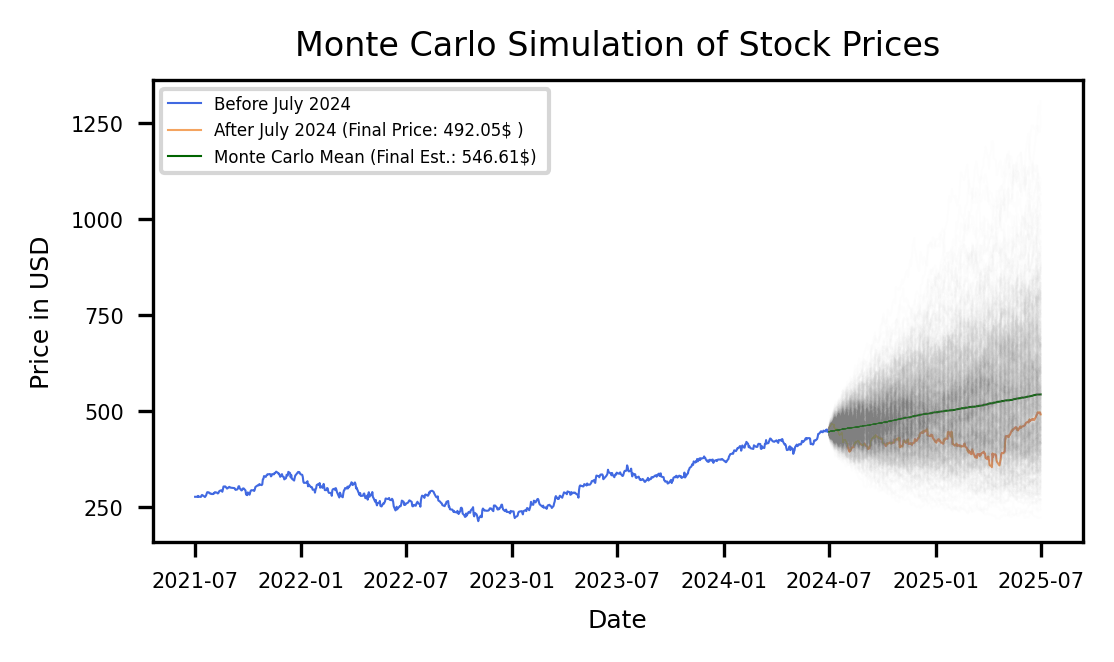

In [760]:
# array in the shape of mc_iterations x 1, with the value of the stock at simulation start (01.07.2024)
last_close_price = np.full((1, mc_iterations), prices_before_july_2024['Schluss'].iloc[-1])

# Dates of the simulation days, set equal to the trading dates in that period.
simulated_dates = prices_after_july_2024["Datum"].reset_index(drop=True)

# Visualizing the Monte Carlo simulation alongside historical data
plt.figure(figsize=(4, 2), dpi=300)

# Taking average of all simulations on the last simulation date.
future_price_mcmc = np.mean(mc_pred_prices[simulation_days, :])

print(f"Average future price after 365 days: ${future_price_mcmc:.2f}")
print(f"Final Date of simulation: {simulated_dates[simulation_days].date()}")

simulated_date = simulated_dates[(simulation_days)].date()
row = prices_after_july_2024[prices_after_july_2024['Datum'] == pd.to_datetime(simulated_date)]
if not row.empty:
    real_price = row.iloc[0]["Schluss"]
    real_date = row.iloc[0]["Datum"]

print(f"Real price on {simulated_date}: ${real_price:.2f}")
print(f"Price difference: ${future_price_mcmc - real_price:.2f}")
print(f"Price difference percentage: {(future_price_mcmc - real_price) / real_price * 100:.2f}%")
print(f"Model accuracy: {100 - abs((future_price_mcmc - real_price) / real_price * 100):.2f}%")


#plot only values starting from 1.July 2021
plt.plot(pd.to_datetime(prices_2021_2024['Datum']), prices_2021_2024['Schluss'], label='Before July 2024', color="royalblue", linewidth=0.5)
plt.plot(pd.to_datetime(prices_after_july_2024['Datum']), prices_after_july_2024['Schluss'], label='After July 2024 (Final Price: 492.05$ )',color="sandybrown", linewidth=0.5)
plt.plot(simulated_dates, mc_pred_prices.mean(axis=1), label='Monte Carlo Mean (Final Est.: 546.61$) ', color="darkgreen", linewidth=0.5)


# Plot each simulation path
for i in range(mc_iterations):
    plt.plot(simulated_dates, mc_pred_prices[:, i], linewidth=0.5, color='gray', alpha=0.01)

plt.title('Monte Carlo Simulation of Stock Prices', fontsize = 8)
plt.xlabel('Date', fontsize = 6)
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
plt.ylabel('Price in USD', fontsize=6)
plt.legend(fontsize = 4)
plt.show()

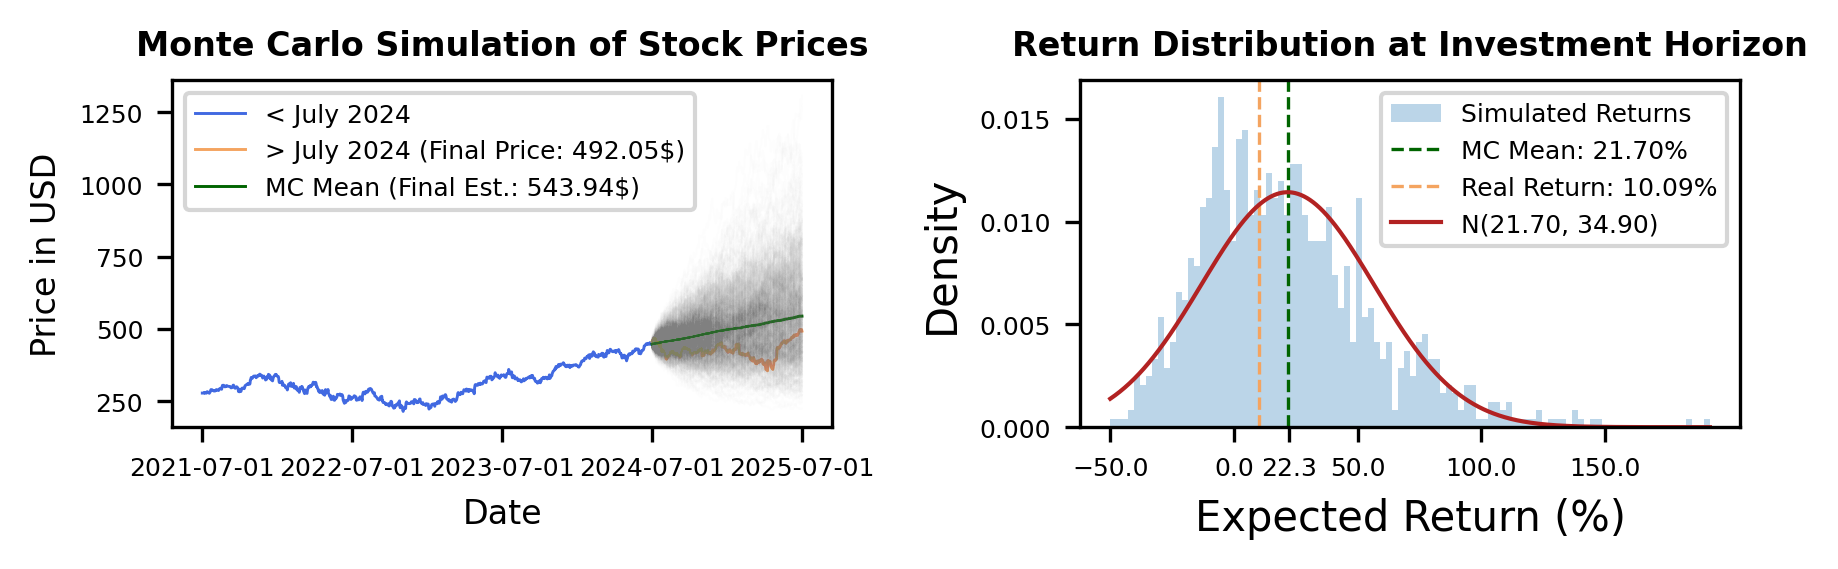

In [763]:
#combine Monte Carlo Plot and Distribution Plot in one aligned next to each other for visualization.

last_close_price = np.full((1, mc_iterations), prices_before_july_2024['Schluss'].iloc[-1])
simulated_dates = prices_after_july_2024["Datum"].reset_index(drop=True)
start_value = microsft.loc[microsft["Datum"] == "2024-06-28", "Schluss"].values

# Monte Carlo stats
future_price_mcmc = np.mean(mc_pred_prices[simulation_days, :])
simulated_date = simulated_dates[(simulation_days)].date()
row = prices_after_july_2024[prices_after_july_2024['Datum'] == pd.to_datetime(simulated_date)]
if not row.empty:
    real_price = row.iloc[0]["Schluss"]

# Return calculations to viusalize the return distribution at maturity
returns = ((mc_pred_prices[simulation_days, :] - start_value) / start_value)
returns_perc = returns * 100
mu, sigma = scipy.stats.norm.fit(returns_perc)
x = np.linspace(min(returns_perc), max(returns_perc), 1000)
pdf = scipy.stats.norm.pdf(x, mu, sigma)

# Create side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2), dpi=300)

# Left plot: Monte Carlo simulation 
ax1.plot(pd.to_datetime(prices_2021_2024['Datum']),
         prices_2021_2024['Schluss'],
         label='< July 2024', linewidth=0.7, color="royalblue")

ax1.plot(pd.to_datetime(prices_after_july_2024['Datum']),
         prices_after_july_2024['Schluss'],
         label=f'> July 2024 (Final Price: {real_price:.2f}$)', linewidth=0.7, color="sandybrown")

ax1.plot(simulated_dates,
         mc_pred_prices.mean(axis=1),
         label=f'MC Mean (Final Est.: {future_price_mcmc:.2f}$)', linewidth=0.7, color="darkgreen")

for i in range(mc_iterations):
    ax1.plot(simulated_dates, mc_pred_prices[:, i], linewidth=0.5, color='gray', alpha=0.01)

custom_x_ticks = ["2021-07", "2022-07", "2023-07", "2024-07", "2025-07"]
ax1.set_xticks(custom_x_ticks)
ax1.set_title('Monte Carlo Simulation of Stock Prices', fontsize=8, fontweight = "bold")
ax1.set_xlabel('Date', fontsize=8)
ax1.set_ylabel('Price in USD', fontsize=8)
ax1.tick_params(axis='both', labelsize=6)
ax1.legend(fontsize=6)

# Add text box with returns
mc_ret = ((future_price_mcmc - start_value) / start_value) * 100
real_ret = ((real_price - start_value) / start_value) * 100

# Right plot: Return Distribution
ax2.hist(returns_perc, bins=100, density=True, alpha=0.3, label='Simulated Returns')
ax2.axvline(mc_ret, linestyle = "--", color ="darkgreen", linewidth = 0.8,  label = f'MC Mean: {mc_ret[0]:.2f}%' )
ax2.axvline(real_ret, linestyle = "--", color ="sandybrown", linewidth = 0.8,  label=f'Real Return: {real_ret[0]:.2f}%')

#custom ticks, to show return values of mc and observed on x axis. 
custom_xticks = [-50, 0, 22.3, 50, 100, 150]

# Annotate values
ax2.plot(x, pdf, linewidth = 1, color="firebrick", label=f'N({mu:.2f}, {sigma:.2f})')
ax2.set_title('Return Distribution at Investment Horizon', fontsize=8, fontweight="bold")
ax2.set_xlabel('Expected Return (%)', fontsize=10)
ax2.set_ylabel('Density', fontsize=10)
ax2.set_xticks(custom_xticks)
ax2.tick_params(axis='both', labelsize=6)
ax2.legend(fontsize=6)

plt.tight_layout()
plt.show()


In [154]:
#performance and risk metrics
mean_return = np.mean(returns)
median_return = np.median(returns)
prob_profit = np.mean(returns > 0)

std_return = np.std(returns)
VaR_95 = np.percentile(returns, 5)
CVaR_95 = returns[returns <= VaR_95].mean()

print(f"Mean return:        {mean_return:.2%}")
print(f"Median return:      {median_return:.2%}")
print(f"Volatility:         {std_return:.2%}")
print(f"Probability > 0:    {prob_profit:.2%}")
print(f"VaR (95%):          {VaR_95:.2%}")
print(f"CVaR (95%):         {CVaR_95:.2%}")

Mean return:        22.30%
Median return:      18.25%
Volatility:         32.73%
Probability > 0:    74.70%
VaR (95%):          -22.85%
CVaR (95%):         -30.87%


## III.2 Performance analysis (with risk management)
Implement a portfolio insurance strategy by including put options to hedge the portfolio against downside risks. Consider fictitious puts, which prices are based on the historical volatility of the underlying, and analyze the impact of 
- the fraction of initial wealth invested in put options, and 
- the strike K of the put options
on the performance and risk measures of the resulting portfolio. Illustrate and discuss
your observations.

In [768]:
## compute risk-free rate using the svenson method at simulation start.
svensson = pd.read_csv("./data/feds200628.csv", delimiter=",", skiprows=9)
svensson["Date"] = pd.to_datetime(svensson["Date"], dayfirst=False)
svensson_params = svensson[svensson["Date"] == "2024-06-28"].reset_index(inplace=False, drop=True)

def svensson_spot_rate(t, beta0, beta1, beta2, beta3, tau1, tau2):
    """
    Compute the spot rate y(t) using the Svensson yield curve model.

    Parameters:
    - t: time to maturity (in years)
    - beta0, beta1, beta2, beta3: Svensson parameters
    - tau1, tau2: decay parameters

    Returns:
    - spot rate y(t)
    """
    term1 = (1 - np.exp(-t / tau1)) / (t / tau1)
    term2 = term1 - np.exp(-t / tau1)
    term3 = (1 - np.exp(-t / tau2)) / (t / tau2) - np.exp(-t / tau2)

    y_t = beta0 + beta1 * term1 + beta2 * term2 + beta3 * term3
    r_t = y_t / 100

    return r_t

maturity_date = pd.to_datetime("2027-03-04")
time_to_maturity = (maturity_date - pd.to_datetime("2024-06-30")).days /252
risk_free_rate_at_sim_start = svensson_spot_rate(time_to_maturity, svensson_params["BETA0"], svensson_params["BETA1"], svensson_params["BETA2"], svensson_params["BETA3"], svensson_params["TAU1"], svensson_params["TAU2"])

In [603]:
# --- Parameters ---
S0 = microsft.loc[microsft["Datum"] == "2024-06-28", "Schluss"].values[0] # initial stock price of simulation
capital = 10000
T = 1     # investment horizon (years)
r = risk_free_rate_at_sim_start  # risk-free rate, calculated using the svensson model
sigma = compute_observed_volatility(prices_before_july_2024["Schluss"], prices_before_july_2024["Eröffnung"])  # historical annualized implied volatility of the microsoft stock
days = simulation_days  # daily steps
dt = T / days

#results from the monecarlo simulation
S_T = np.array(mc_pred_prices[-1,:]).flatten() # Final prices

# --- Black-Scholes Put Pricing ---
def bs_put_price(S, K, T, r, sigma,):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    price = K * np.exp(-r * T) * scipy.stats.norm.cdf(-d2) - S * scipy.stats.norm.cdf(-d1)

    return float(price)


# --- Portfolio Simulation ---
put_fractions = np.linspace(0.0, 0.33, 50)  # 0% to 20% in puts
strikes = np.linspace(S0 - 100 , S0 , 100)       # strike prices of the put options. 

results = []

for K in strikes:

    put_price = bs_put_price(S0, K, T, r, sigma) #compute the price of the put option given the strike price.

    for wealth_in_put in put_fractions:

        wealth_in_stock = 1 - wealth_in_put
        n_puts = (wealth_in_put * capital) / put_price  # number of puts purchased
        n_stocks = (wealth_in_stock * capital) / S0 #number of stocks purchased

        # Portfolio value at maturity
        payoff_put = np.maximum(K - S_T, 0).flatten()

        portfolio_value = n_stocks * S_T  + n_puts * np.array(payoff_put).flatten()


        returns = portfolio_value / capital -1
        #returns = np.log(returns)

        # Risk/Performance Measures
        mean_return = np.mean(returns)
        std_dev = np.std(returns)
        downside_dev = np.std(returns[returns < 0])
        VaR_95 = np.percentile(returns, 5)
        CVaR_95 = returns[returns <= VaR_95].mean()
        prob_loss = np.mean(returns < 0)

        results.append({
            'Strike': K,
            'Put Price': put_price,
            'PutFraction': wealth_in_put,
            'MeanReturn': mean_return,
            'StdDev': std_dev,
            'DownsideDev': downside_dev,
            'VaR_95': VaR_95,
            'CVaR_95': CVaR_95,
            'ProbLoss': prob_loss
        })

results = pd.DataFrame(results)

/var/folders/zb/_v_3sbq938jftd_b07f5kpfm0000gn/T/ipykernel_86132/3979584047.py:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(price)


In [605]:
# Convert values to percent for consistent y-axis
results['MeanReturn'] *= 100
results['StdDev'] *= 100
results['VaR_95'] *= 100
results['CVaR_95'] *= 100
results['ProbLoss'] *= 100

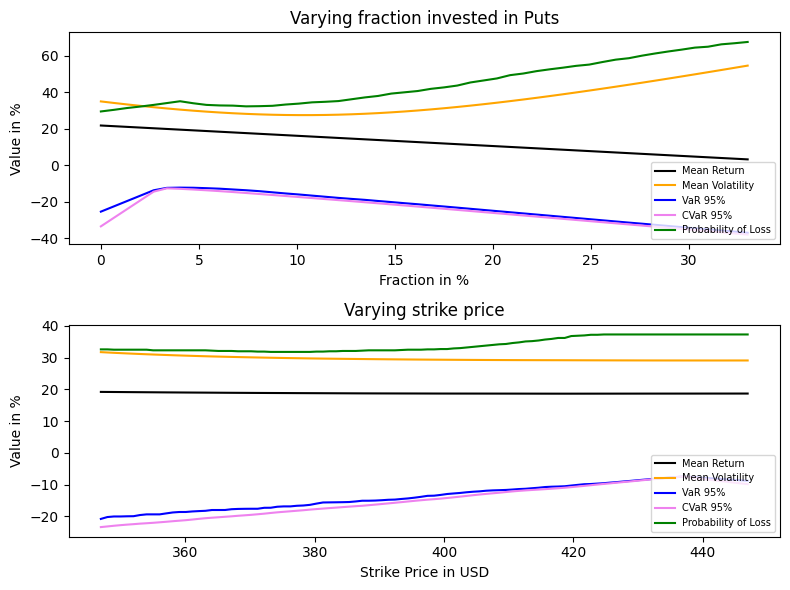

In [607]:

# Create 2-subplot figure
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharey=False)

# Top plot: Varying put fraction
axes[0].plot(df_at_strike['PutFraction'] * 100, df_at_strike['MeanReturn'], 'k-', label='Mean Return')
axes[0].plot(df_at_strike['PutFraction'] * 100, df_at_strike['StdDev'], 'orange', label='Mean Volatility')
axes[0].plot(df_at_strike['PutFraction'] * 100, df_at_strike['VaR_95'], 'blue', label='VaR 95%')
axes[0].plot(df_at_strike['PutFraction'] * 100, df_at_strike['CVaR_95'], 'violet', label='CVaR 95%')
axes[0].plot(df_at_strike['PutFraction'] * 100, df_at_strike['ProbLoss'], 'green', label='Probability of Loss')

axes[0].set_title("Varying fraction invested in Puts")
axes[0].set_xlabel("Fraction in %")
axes[0].set_ylabel("Value in %")
axes[0].legend(fontsize = 7, loc='lower right')

# Bottom plot: Varying strike
axes[1].plot(df_strike_given_put_fraction['Strike'], df_strike_given_put_fraction['MeanReturn'], 'k-', label='Mean Return')
axes[1].plot(df_strike_given_put_fraction['Strike'], df_strike_given_put_fraction['StdDev'], 'orange', label='Mean Volatility')
axes[1].plot(df_strike_given_put_fraction['Strike'], df_strike_given_put_fraction['VaR_95'], 'blue', label='VaR 95%')
axes[1].plot(df_strike_given_put_fraction['Strike'], df_strike_given_put_fraction['CVaR_95'], 'violet', label='CVaR 95%')
axes[1].plot(df_strike_given_put_fraction['Strike'], df_strike_given_put_fraction['ProbLoss'], 'green', label='Probability of Loss')

axes[1].set_title("Varying strike price")
axes[1].set_xlabel("Strike Price in USD")
axes[1].set_ylabel("Value in %")
axes[1].legend(fontsize = 7, loc='lower right')

plt.tight_layout()
plt.show()

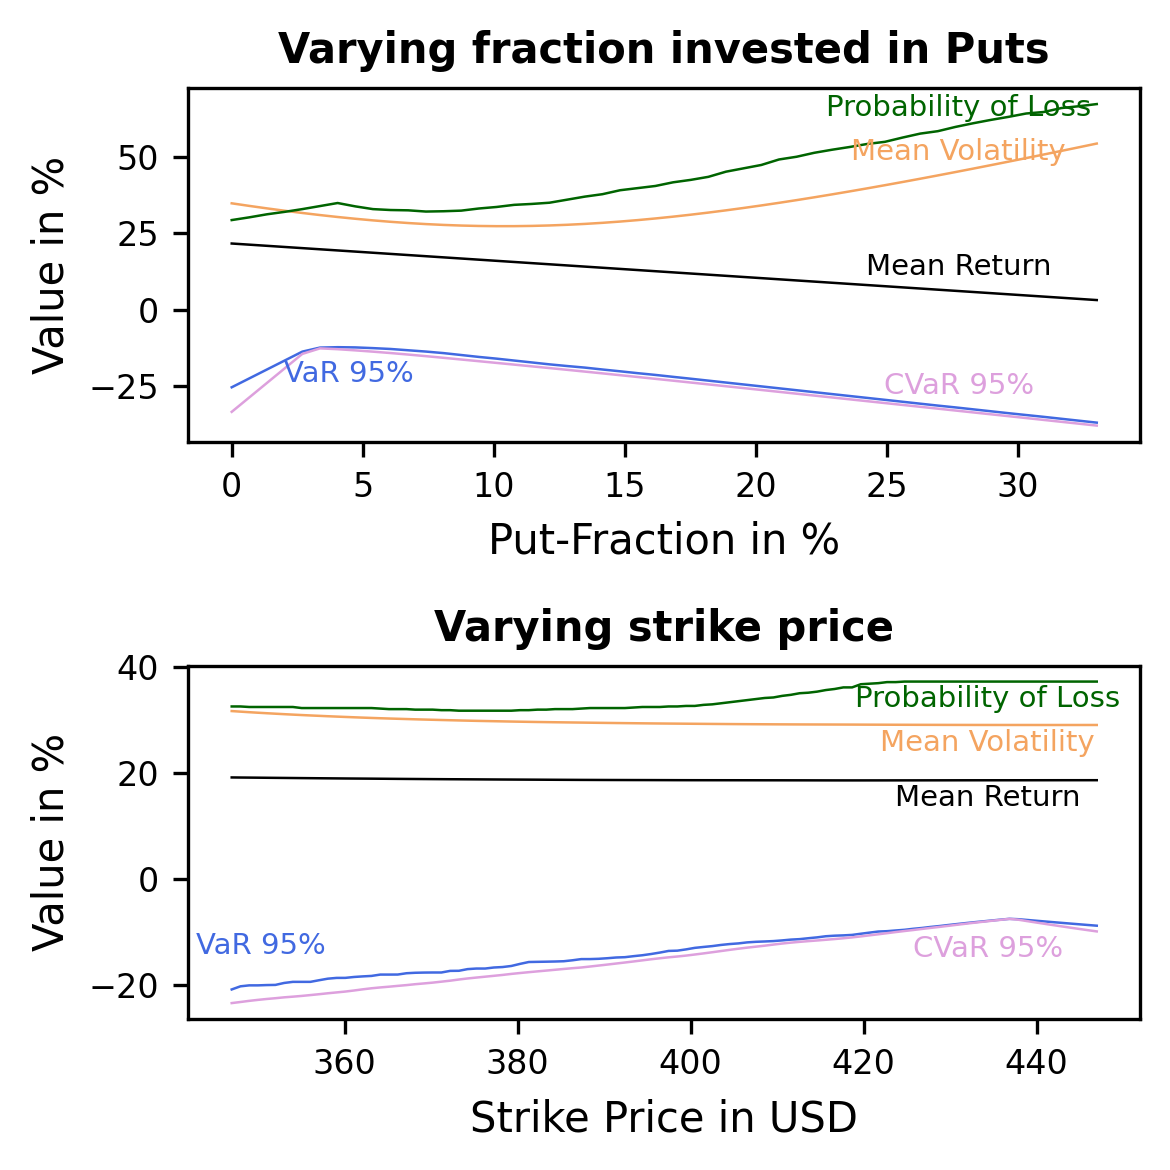

In [765]:
# Get fixed strike price at 90 Percent of stock price at start date (1.July.2024)

df_at_strike = results[np.isclose(results["Strike"], S0*0.9, atol=0.5)]

# Get one put fraction for the bottom plot
df_strike_given_put_fraction = results[np.isclose(results["PutFraction"], 0.0538, atol=1e-3)]

#different alignment of the Plots.
fig, axes = plt.subplots(2, 1, figsize=(4, 4), dpi=300 )

# Top plot: Varying fraction invested in puts
x1 = df_at_strike['PutFraction'] * 100
metrics = {
    'MeanReturn': ('black', 'Mean Return'),
    'StdDev': ('sandybrown', 'Mean Volatility'),
    'VaR_95': ('royalblue', 'VaR 95%'),
    'CVaR_95': ('plum', 'CVaR 95%'),
    'ProbLoss': ('darkgreen', 'Probability of Loss')
}

for key, (color, label) in metrics.items():
    y = df_at_strike[key]
    axes[0].plot(x1, y, color=color, linewidth = 0.6)
    
    # Annotate at last point
    if label == 'VaR 95%':
        axes[0].annotate(
            label,
            xy=(x1.iloc[1]+3, y.iloc[1]-3),
            xytext=(5, 0),
            textcoords='offset points',
            fontsize=7,
            color=color,
            ha='center',
            va='bottom')
    else: 
        axes[0].annotate(
            label,
            xy=(x1.iloc[-10], y.iloc[-10]+3),
            xytext=(5, 0),
            textcoords='offset points',
            fontsize=7,
            color=color,
            ha='center',
            va='bottom'
        )

axes[0].set_title("Varying fraction invested in Puts", fontsize=10, fontweight="bold")
axes[0].set_xlabel("Put-Fraction in %", fontsize=10)
axes[0].set_ylabel("Value in %", fontsize=10)
axes[0].tick_params(axis='both', labelsize=8)

# Bottom plot: Varying strike
x2 = df_strike_given_put_fraction['Strike']

for key, (color, label) in metrics.items():
    y = df_strike_given_put_fraction[key]
    axes[1].plot(x2, y, color=color, linewidth = 0.6)
    # Annotate at last point
    if label == 'VaR 95%':
        axes[1].annotate(
            label,
            xy=(x2.iloc[1], y.iloc[1]+5),
            xytext=(5, 0),
            textcoords='offset points',
            fontsize=7,
            color=color,
            ha='center',
            va='bottom')
    else: 
        axes[1].annotate(
            label,
            xy=(x2.iloc[-1]-15, y.iloc[-1]-6),
            xytext=(5, 0),
            textcoords='offset points',
            fontsize=7,
            color=color,
            ha='center',
            va='bottom'
        )

axes[1].set_title("Varying strike price",fontsize=10, fontweight="bold")
axes[1].set_xlabel("Strike Price in USD", fontsize=10)
axes[1].set_ylabel("Value in %", fontsize=10)
axes[1].tick_params(axis='both', labelsize=8)

plt.tight_layout()
plt.show()

## III.3 Stress Scenario Analysis
For a specific portfolio allocation from Problem IX, consider that the volatility for pricing purposes of the options equals the historical volatility of the underlying ±5 percentage points and/or a sudden drop in the stock/index price by 20% after half a year. Compare the results and explain.

In [642]:
sigma = 0.20834
volatilities = [sigma-0.05, sigma, sigma+0.05]
wealth_in_put = 0.05 #0.206061
S0 = S0 #Spot Price at inital start price of simulation
K = S0 #set strike price equal to current spot.

In [643]:
#compute metrics for varying volatility with unchanged stock price value
stress_test_volatilities = []
for i in volatilities:
    put_price = bs_put_price(S0, K, T, r, i)

    wealth_in_stock = 1 - wealth_in_put
    n_puts = (wealth_in_put * capital) / put_price  # number of puts purchased
    n_stocks = (wealth_in_stock * capital) / S0

    # Portfolio value at maturity
    payoff_put = np.maximum(K - S_T, 0)
    portfolio_value = n_stocks * S_T + n_puts * payoff_put

    returns = portfolio_value / capital -1
    #returns = np.log(returns)

    # Risk/Performance Measures
    mean_return = np.mean(returns)
    std_dev = np.std(returns)
    downside_dev = np.std(returns[returns < 0])
    VaR_95 = np.percentile(returns, 5)
    CVaR_95 = returns[returns <= VaR_95].mean()
    prob_loss = np.mean(returns < 0)

    stress_test_volatilities.append({
        'Volatily': i,
        'Strike': K,
        'PutFraction': wealth_in_put,
        'MeanReturn': mean_return,
        'StdDev': std_dev,
        'DownsideDev': downside_dev,
        'VaR_95': VaR_95,
        'CVaR_95': CVaR_95,
        'ProbLoss': prob_loss
    })



/var/folders/zb/_v_3sbq938jftd_b07f5kpfm0000gn/T/ipykernel_86132/3979584047.py:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(price)


In [758]:
stress_test_volatilities = pd.DataFrame(stress_test_volatilities)

In [632]:
#run simualation with price drop after half a year by 20%
def monte_carlo_simulation_with_midshock(data, days, iterations, shock_drop=0.2):
    if isinstance(data, pd.Series):
        data = data.to_numpy()
    if not isinstance(data, np.ndarray):
        raise TypeError("Data must be a numpy array or pandas Series")

    log_returns = np.log(data[1:] / data[:-1])
    mu = np.mean(log_returns)
    sigma = np.var(log_returns)
    std = np.std(log_returns)

    dt = 1
    drift = mu - 0.5 * sigma

    halfway = days // 2
    current_price = data[-1]

    # simulate up to halfway
    Z1 = np.random.normal(0, 1, size=(halfway, iterations))
    shocks1 = drift * dt + std * np.sqrt(dt) * Z1

    prices = np.zeros((days + 1, iterations))
    prices[0] = current_price
    for t in range(1, halfway + 1):
        prices[t] = prices[t - 1] * np.exp(shocks1[t - 1])

    # apply 20% drop
    prices[halfway] *= (1 - shock_drop)

    # simulate after drop
    Z2 = np.random.normal(0, 1, size=(days - halfway, iterations))
    shocks2 = drift * dt + std * np.sqrt(dt) * Z2

    for t in range(halfway + 1, days + 1):
        prices[t] = prices[t - 1] * np.exp(shocks2[t - halfway - 1])

    return prices


In [637]:
mc_price_drop = monte_carlo_simulation_with_midshock(prices_before_july_2024["Schluss"],simulation_days, mc_iterations )
S_T_price_drop = mc_price_drop[-1,:]

In [638]:
#compute error metrics with stock drop of 20%
stress_test_stock_drop = []
for i in volatilities:
    put_price = bs_put_price(S0, K, T, r, i)

    wealth_in_stock = 1 - wealth_in_put
    n_puts = (wealth_in_put * capital) / put_price  # number of puts purchased
    n_stocks = (wealth_in_stock * capital) / S0

    # Portfolio value at maturity
    payoff_put = np.maximum(K - S_T_price_drop, 0)
    portfolio_value = n_stocks * S_T_price_drop+ n_puts * payoff_put

    returns = portfolio_value/ capital -1
    #returns = np.log(returns)

    # Risk/Performance Measures
    mean_return = np.mean(returns)
    std_dev = np.std(returns)
    downside_dev = np.std(returns[returns < 0])
    VaR_95 = np.percentile(returns, 5)
    CVaR_95 = returns[returns <= VaR_95].mean()
    prob_loss = np.mean(returns < 0)

    stress_test_stock_drop.append({
        'Volatily': i,
        'Strike': K,
        'PutFraction': wealth_in_put,
        'MeanReturn': mean_return,
        'StdDev': std_dev,
        'DownsideDev': downside_dev,
        'VaR_95': VaR_95,
        'CVaR_95': CVaR_95,
        'ProbLoss': prob_loss
    })

/var/folders/zb/_v_3sbq938jftd_b07f5kpfm0000gn/T/ipykernel_86132/3979584047.py:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(price)


In [759]:
stress_test_stock_drop = pd.DataFrame(stress_test_stock_drop)

In [655]:
stress_scenario_analysis = pd.concat([stress_test_volatilities , stress_test_stock_drop])
stress_scenario_analysis*= 100
stress_scenario_analysis

,Volatily,Strike,PutFraction,MeanReturn,StdDev,DownsideDev,VaR_95,CVaR_95,ProbLoss
0,15.834,44695.0,5.0,20.698427,27.931377,1.390717,-4.143320,-4.563199,30.3
1,20.834,44695.0,5.0,19.141238,29.238987,2.390026,-8.540339,-9.659979,36.7
2,25.834,44695.0,5.0,18.309053,30.053928,4.422460,-13.428567,-16.094120,36.7
0,15.834,44695.0,5.0,6.524905,14.868447,1.420990,-4.433545,-4.699357,42.6
1,20.834,44695.0,5.0,2.361354,17.025072,2.484285,-10.548039,-11.522098,65.2
2,25.834,44695.0,5.0,0.136290,18.659010,5.133616,-18.208345,-20.527309,65.2


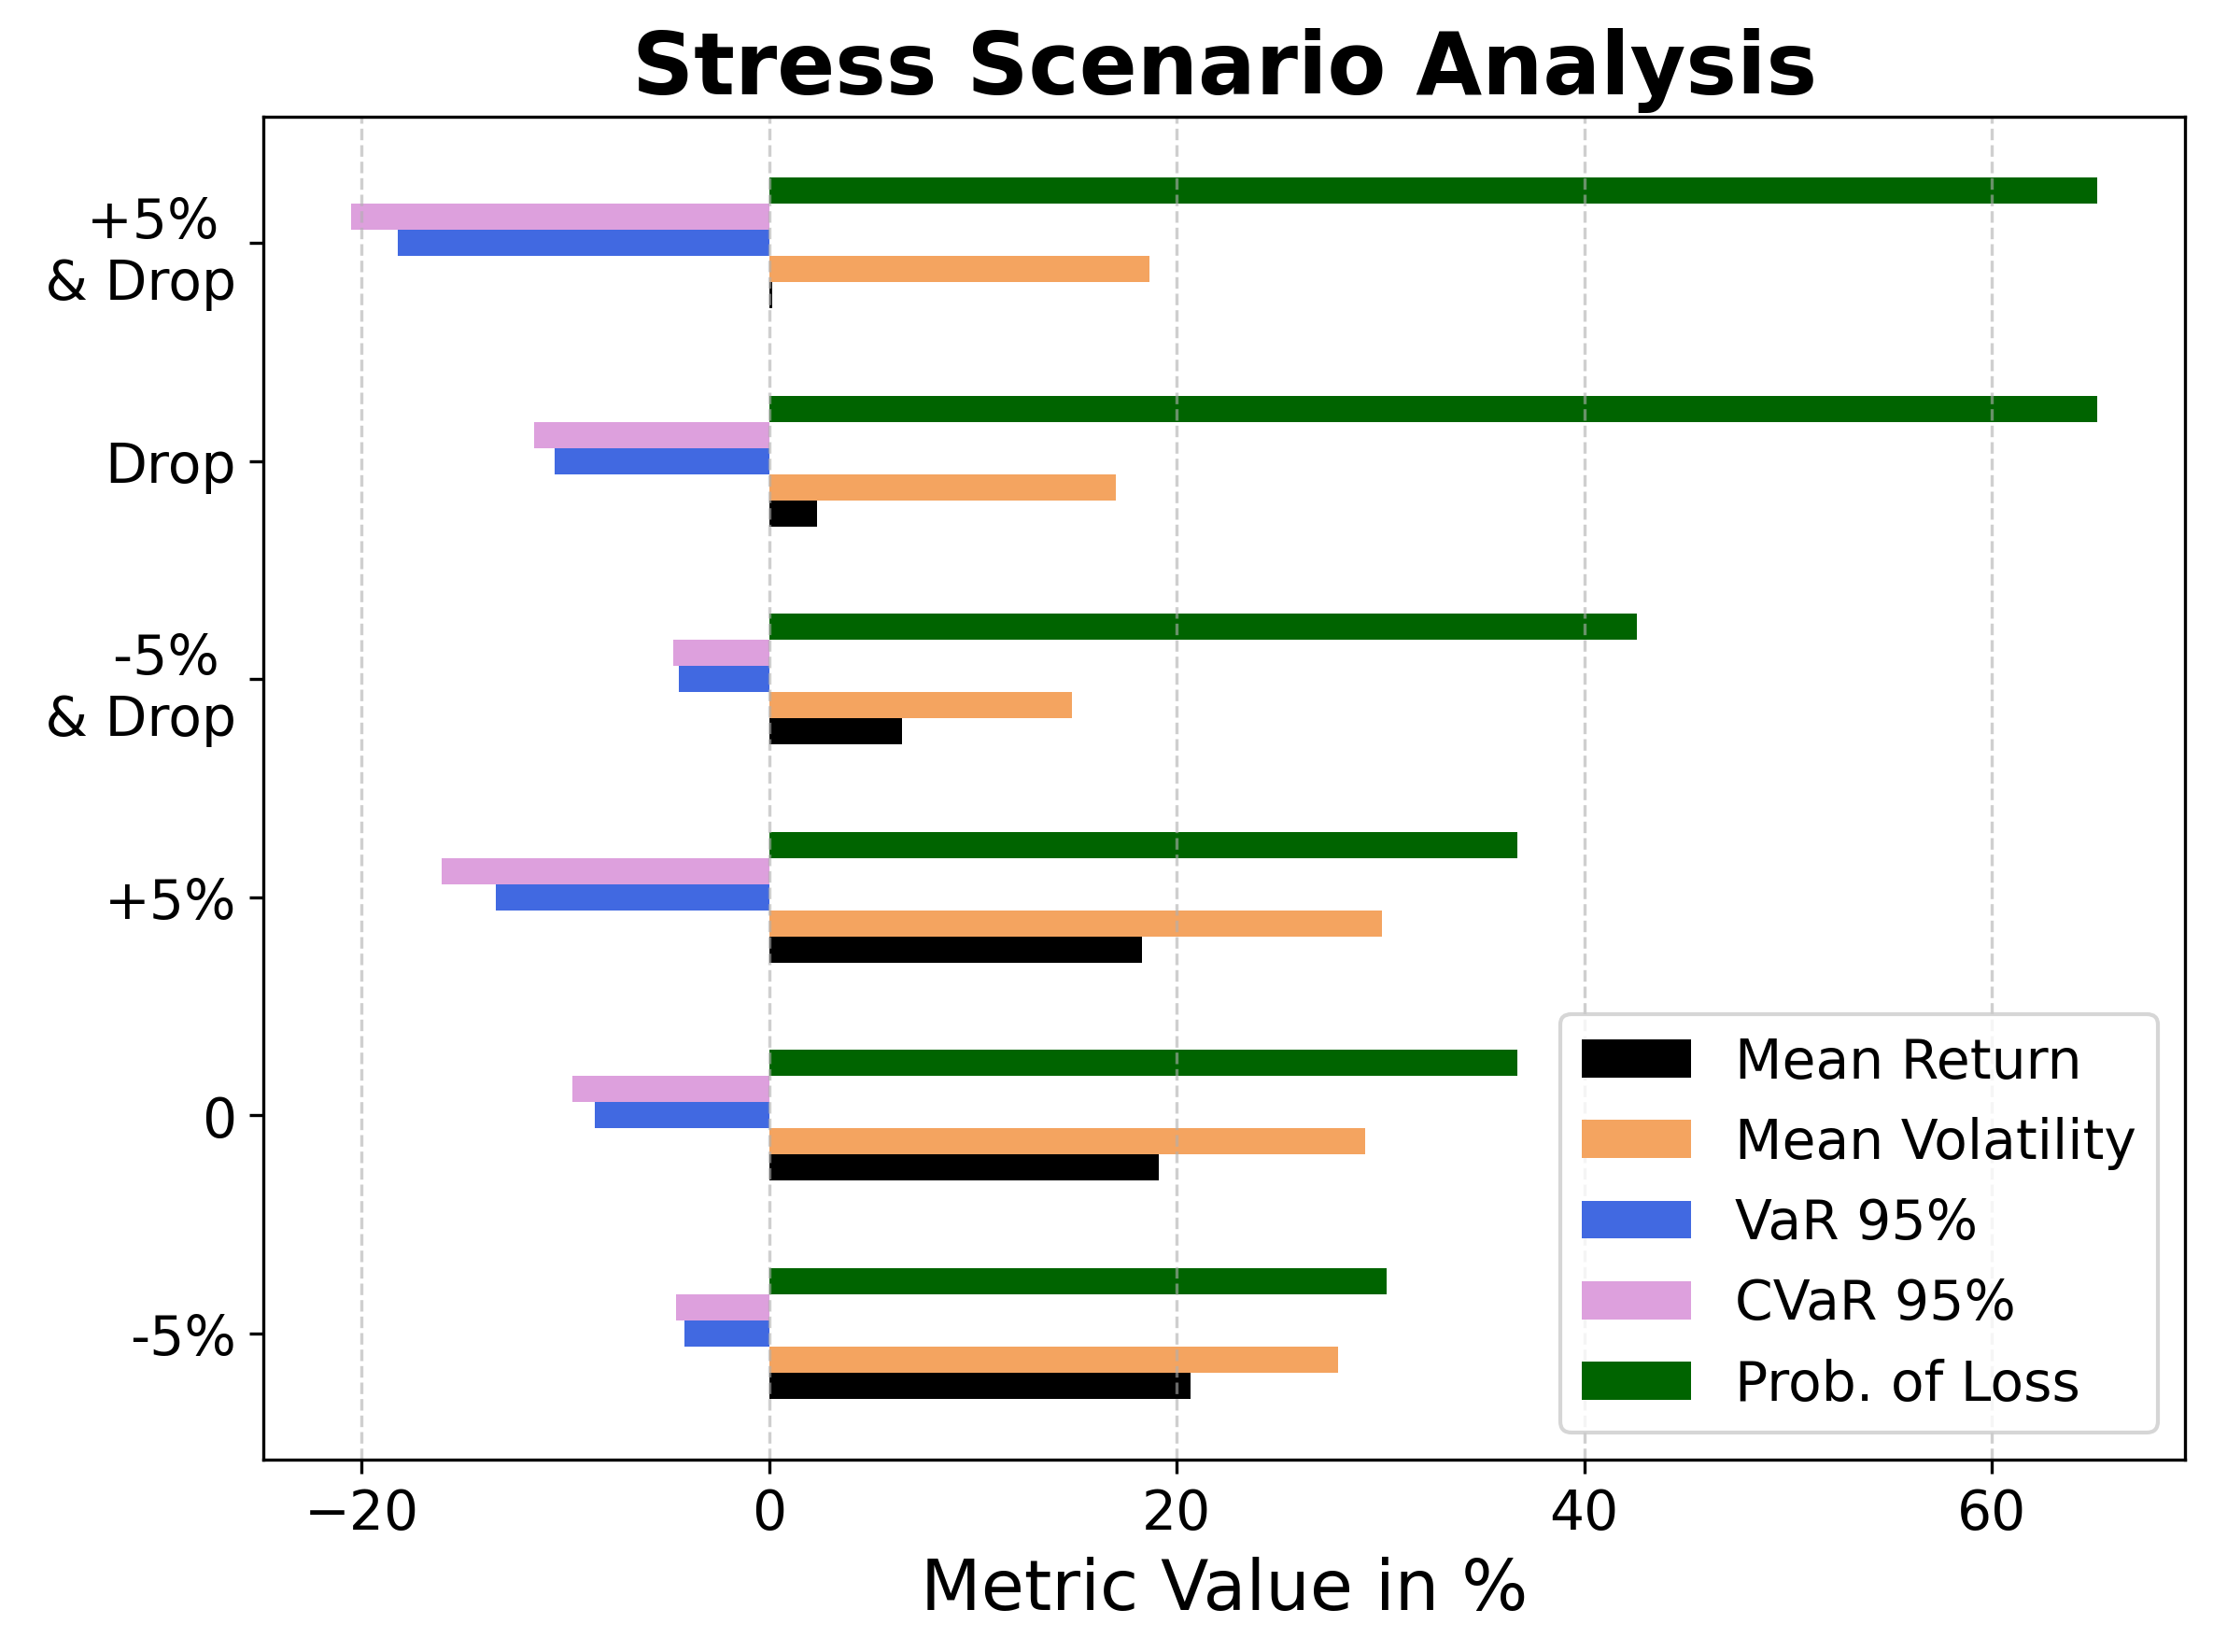

In [767]:
#Visualize Risk and Perfomance Metrics for the Stress Scenario Analysis.

# Data 
stress_scenario_analysis['Scenario'] = ['-5%', '0', '+5%', '-5% \n & Drop', 'Drop', '+5% \n & Drop']
df = stress_scenario_analysis.copy()

# Metric color and label map
metrics = {
    'MeanReturn': ('black', 'Mean Return'),
    'StdDev': ('sandybrown', 'Mean Volatility'),
    'VaR_95': ('royalblue', 'VaR 95%'),
    'CVaR_95': ('plum', 'CVaR 95%'),
    'ProbLoss': ('darkgreen', 'Prob. of Loss')
}

metric_keys = list(metrics.keys())
scenarios = df['Scenario'].values
n_scenarios = len(scenarios)
n_metrics = len(metric_keys)

# Matrix: shape = (n_scenarios, n_metrics)
data_matrix = df[metric_keys].values
x = np.arange(n_scenarios)
bar_height = 0.12

# Plot setup
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

# Plot each metric per scenario with specified color
for i, key in enumerate(metric_keys):
    color, label = metrics[key]
    offset = (i - n_metrics / 2) * bar_height + bar_height / 2
    ax.barh(
        x + offset,
        data_matrix[:, i],
        height=bar_height,
        color=color,
        label=label
    )

# Labels and formatting
ax.set_yticks(x)
ax.set_yticklabels(scenarios, fontsize=14)
ax.set_xlabel('Metric Value in %', fontsize=18)
ax.set_title('Stress Scenario Analysis', fontsize = 22, fontweight="bold")
ax.legend(loc='lower right', fontsize=14)
ax.tick_params(labelsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


